In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).




# 1. 1: Import necesary library




In [4]:
# import necessary library
import pandas as pd # pandas for reading csv file
from sklearn.preprocessing import MinMaxScaler #standadlize data in (a,b) form
import numpy as np #hadnling data
from keras.models import Sequential #create the sequential neural network
from keras.layers import Dense, Dropout, LSTM #the model that we use
from keras.optimizers import Adam # for optimization purpose
from keras.metrics import Accuracy # to evaluate the accuracy of lstm model
import matplotlib.pyplot as plt # for plotting data into graph form




# 2.Data handling








## a) Get raw data













In [5]:
df = pd.read_csv("drive/MyDrive/HistoricalData_meta.csv")
print(df.head()) # print raw data form

        Date   Close    Volume    Open    High     Low
0  6/30/2023  286.98  19694870  284.76  289.05  284.42
1  6/29/2023  281.53  15395690  284.50  286.57  280.69
2  6/28/2023  285.29  16722120  284.82  289.55  284.06
3  6/27/2023  287.05  26108260  282.01  289.35  280.66
4  6/26/2023  278.47  24232650  288.70  289.79  277.60


Handling data in correct form

## b) Handle "close" column

### Calculate the simple moving averagement (SMA)

In [19]:
# Load data
company="FB"
df['H-L'] = df['High'] - df['Low']  #the difference between hight and low value of stock in current day
df['O-C'] = df['Open'] - df['Close'] # the difference between the open price and close price in current day
# we calculate the simple moving avaragement (SMA)
# the window size of each SMA , ma_1, ma_2 and ma_3
ma_1 = 7
ma_2 = 14
ma_3 = 21
# calculate the SMA of close price with window's size as ma_1, ma_2, ma_3
"""
we denote CP(n) = close price of n-th day
    Fomular of SMA = (CP(1)+CP(2)+...+CP(n))/n; where n is window size

    for example if we have data like
    data  weight
    1     12
    2     23
    3     40
    then the simple moving averagement (SMA) with window =2
     data  weight  SMA_2
    1     12      NaN
    2     23      17.5
    3     40      31.5

"""
df[f'SMA_{ma_1}'] = df['Close'].rolling(window=ma_1).mean()
df[f'SMA_{ma_2}'] = df['Close'].rolling(window=ma_2).mean()
df[f'SMA_{ma_3}'] = df['Close'].rolling(window=ma_3).mean()
print(df.tail())

          Date  Close    Volume   Open   High    Low   H-L   O-C      SMA_7  \
2513  7/8/2013  24.71  27043580  24.47  25.04  24.42  0.62 -0.24  25.758571   
2514  7/5/2013  24.37  20202440  24.65  24.66  24.20  0.46  0.28  25.480000   
2515  7/3/2013  24.52  10404330  24.22  24.71  24.15  0.56 -0.30  25.228571   
2516  7/2/2013  24.41  18346010  24.70  24.77  24.30  0.47  0.29  25.014286   
2517  7/1/2013  24.81  20539520  24.97  25.06  24.62  0.44  0.16  24.871429   

         SMA_14     SMA_21      SD_7     SD_21  
2513  26.576429  30.031905  0.546426  5.420503  
2514  25.862857  29.326190  0.690555  5.125256  
2515  25.720714  28.681905  0.670856  4.814781  
2516  25.597857  28.059048  0.656325  4.450629  
2517  25.509286  27.488095  0.555321  4.021619  
Done Loading Data


### Calculate the Standard Deviation(SD)

In [20]:
# calculate the Standard deviation (SD) of close column
"""
The fomular of standard deviation
     + calculate varience
        Var = (1/n) * Σ(xi - mean)^2
     + Standard deviation = sqrt(Var)
Example
   Col1  Col2        SD
0     1     6       NaN
1     2     7       NaN
2     3     8  1.000000
3     4     9  1.000000
4     5    10  1.000000
"""
df[f'SD_{ma_1}'] = df['Close'].rolling(window=ma_1).std()
df[f'SD_{ma_3}'] = df['Close'].rolling(window=ma_3).std()
# remove all the row with value "Nan" in df
df.dropna(inplace=True)
df.to_csv(f"{company}.csv")
print(df.head())
print("Done Loading Data")

          Date   Close    Volume    Open    High     Low    H-L   O-C  \
280  5/18/2022  192.24  23959970  200.00  201.00  191.63   9.37  7.76   
281  5/17/2022  202.62  24872730  202.12  205.46  198.36   7.10 -0.50   
282  5/16/2022  200.04  27112600  197.05  205.37  195.93   9.44 -2.99   
283  5/13/2022  198.62  24549840  192.58  199.89  191.28   8.61 -6.04   
284  5/12/2022  191.24  38262230  187.06  198.05  184.78  13.27 -4.18   

          SMA_7      SMA_14      SMA_21      SD_7      SD_21  
280  190.005714  191.927857  185.781429  5.397379  12.015679  
281  191.575714  192.425714  187.769524  7.234383  11.107398  
282  193.891429  192.839286  189.230952  6.929744  10.568634  
283  196.368571  193.399286  190.892381  4.252170   8.982786  
284  195.655714  192.855000  192.177143  4.676387   6.595389  
Done Loading Data


## c) Processing Data


### Convert data in range (0,1)

In [29]:
# create 2 object of MinMaxScaler class for standardlizing data in correct form
scala_x = MinMaxScaler(feature_range=(0, 1))
scala_y = MinMaxScaler(feature_range=(0, 1))
# those below column will be reshape
cols_x = ['H-L', 'O-C', f'SMA_{ma_1}', f'SMA_{ma_2}', f'SMA_{ma_3}', f'SD_{ma_1}', f'SD_{ma_3}']
cols_y = ['Close']
# convert data frame to 2-D array
"""
      in reshape function
      -1 allow numpy automatically calculate a suitable row for array
      len(cols_x) and len(col_y) is represented for number of column
"""
Array_X = df[cols_x].values.reshape(-1, len(cols_x))
Array_Y = df[cols_y].values.reshape(-1, len(cols_y))
print(Array_X)
# convert value of Array_X and Array_Y to (0,1)
"""
        we have the convertion fomular
              scaled_value = (value - min_value) / (max_value - min_value)
        example : Array_X = [[1 2 3] [2 3 4]]
          column 1 :  scaled_value = (1 - 1) / (2 - 1) = 0 / 1 = 0
                      scaled_value = (2 - 1) / (2 - 1) = 1 / 1 = 1
        then similar to column 2 and 3, we have the output of convert value of Array_X to interval (0,1) is
        [[0. 0. 0.] [1. 1. 1.]]

"""
scaled_data_x = scala_x.fit_transform(Array_X)
scaled_data_y = scala_y.fit_transform(Array_Y)
print(scaled_data_x)

[[ 9.37000000e+00  7.76000000e+00  1.90005714e+02 ...  1.85781429e+02
   5.39737855e+00  1.20156786e+01]
 [ 7.10000000e+00 -5.00000000e-01  1.91575714e+02 ...  1.87769524e+02
   7.23438285e+00  1.11073982e+01]
 [ 9.44000000e+00 -2.99000000e+00  1.93891429e+02 ...  1.89230952e+02
   6.92974369e+00  1.05686337e+01]
 ...
 [ 5.60000000e-01 -3.00000000e-01  2.52285714e+01 ...  2.86819048e+01
   6.70855886e-01  4.81478101e+00]
 [ 4.70000000e-01  2.90000000e-01  2.50142857e+01 ...  2.80590476e+01
   6.56324543e-01  4.45062906e+00]
 [ 4.40000000e-01  1.60000000e-01  2.48714286e+01 ...  2.74880952e+01
   5.55320586e-01  4.02161860e+00]]
[[4.15441176e-01 6.98737374e-01 4.66240199e-01 ... 4.58701595e-01
  1.08480382e-01 2.59784430e-01]
 [3.11121324e-01 4.90151515e-01 4.70672937e-01 ... 4.64462687e-01
  1.47137424e-01 2.38873836e-01]
 [4.18658088e-01 4.27272727e-01 4.77211126e-01 ... 4.68697607e-01
  1.40726743e-01 2.26470304e-01]
 ...
 [1.05698529e-02 4.95202020e-01 1.00835727e-03 ... 3.45941500e

### Devide data

In [32]:
pre_day = 30 # size of array's element in element of x_total
test_size=365 # size of testing data
x_total = []
y_total = []
for i in range(pre_day, len(df)):
    x_total.append(scaled_data_x[i-pre_day:i])
    y_total.append(scaled_data_y[i])
# divide x_total in y_total into training and testing data
x_train = np.array(x_total[:len(x_total)-test_size])
x_test = np.array(x_total[len(x_total)-test_size:])
y_train = np.array(y_total[:len(y_total)-test_size])
y_test = np.array(y_total[len(y_total)-test_size:])


# 3.  3.Building and Training Model




In [37]:
# Create the sequential neural network model
"""
    we initialize a sequential model using Sequential()
    Then we add new layer to this sequential
"""
model = Sequential()
# add LSTM to new layer
"""
      units=60: This parameter specifies the number of LSTM units or memory cells in the layer.
      return the entire sequence of outputs or just the last output
"""
model.add(LSTM(units=60, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
# add dropout(0.2) to prevent overfitting
model.add(Dropout(0.2))

"""
    we add multi-layer to this model because it will help
       + Increased model capacity: Each layer in a neural network adds more parameters and learning capacity,
                              allowing the model to capture and represent more complex patterns in the data.
       + Improved model generalization : the model becomes less prone to overfitting.
                                         Deep networks with multiple layers and appropriate regularization techniques,
                                         such as Dropout, can prevent the model from memorizing noise or irrelevant details in the training data.
"""
model.add(LSTM(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=60))
model.add(Dropout(0.2))
model.add(Dense(units=len(cols_y)))

# use mean_squared_error function to minimize the squared differences between predicted and actual values.
model.compile(optimizer='adam', loss='mean_squared_error')
"""
      epochs is the number of time that model has been train base on entity dataset
      steps_per_epoch is the number of time that model has been train in each epochs
"""
model.fit(x_train, y_train, epochs=120, steps_per_epoch=40, use_multiprocessing=True)
# save model to reducing the next time of executing prediction
model.save(f"{company}.h5")
print("Done Training Model")

Epoch 1/120
40/40 [==============================] - 56s 80ms/step - loss: 0.0289
Epoch 2/120
40/40 [==============================] - 4s 100ms/step - loss: 0.0052
Epoch 3/120
40/40 [==============================] - 3s 70ms/step - loss: 0.0049
Epoch 4/120
40/40 [==============================] - 3s 69ms/step - loss: 0.0045
Epoch 5/120
40/40 [==============================] - 3s 75ms/step - loss: 0.0042
Epoch 6/120
40/40 [==============================] - 3s 85ms/step - loss: 0.0036
Epoch 7/120
40/40 [==============================] - 3s 70ms/step - loss: 0.0039
Epoch 8/120
40/40 [==============================] - 3s 70ms/step - loss: 0.0034
Epoch 9/120
40/40 [==============================] - 3s 71ms/step - loss: 0.0034
Epoch 10/120
40/40 [==============================] - 4s 104ms/step - loss: 0.0031
Epoch 11/120
40/40 [==============================] - 3s 82ms/step - loss: 0.0038
Epoch 12/120
40/40 [==============================] - 3s 69ms/step - loss: 0.0031
Epoch 13/120
40/40 [==

# Testing

12/12 [==============================] - 1s 15ms/step


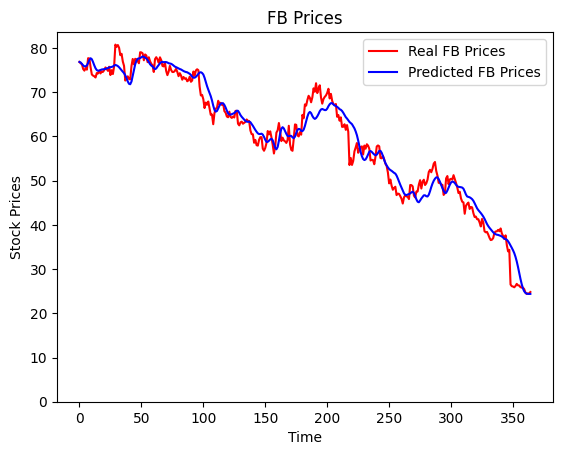

In [38]:
# Testing
predict_prices = model.predict(x_test)
predict_prices = scala_y.inverse_transform(predict_prices)

# Ploting the Stat
real_price = df[len(df)-test_size:]['Close'].values.reshape(-1, 1)
real_price = np.array(real_price)
real_price = real_price.reshape(real_price.shape[0], 1)


plt.plot(real_price, color="red", label=f"Real {company} Prices")
plt.plot(predict_prices, color="blue", label=f"Predicted {company} Prices")
plt.title(f"{company} Prices")
plt.xlabel("Time")
plt.ylabel("Stock Prices")
plt.ylim(bottom=0)
plt.legend()
plt.show()
